# <center> **Forecasting the crowd at a given location.**

- Contents
  - Downloading the required data.
  - Importing the required python libraries for analysis and prediction.
  - Analysis of the data.
  - Data preparation.
    - Rough estimation of time taken to visit this place from entry to exit.
  - Time Series Model.
    - Baseline SARIMA model.
      - Why SARIMA?
    - Testing Facebook Prophet model on the data.
      - Why FB Prophet?
  - Conclusion.

**Note about the dataset** - All the datasets used for analysis and prediction have been **randomly generated** and do not represent real world behaviour.

### Downloading Datasets

In [ ]:
!wget 'https://raw.githubusercontent.com/atulsnjena/small-datasets-hosting/main/travio_exits.csv'
!wget 'https://raw.githubusercontent.com/atulsnjena/small-datasets-hosting/main/travio_large.csv'

--2022-03-29 18:01:33--  https://raw.githubusercontent.com/atulsnjena/small-datasets-hosting/main/travio_exits.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7562 (7.4K) [text/plain]
Saving to: ‘travio_exits.csv.3’

travio_exits.csv.3  100%[===================>]   7.38K  --.-KB/s    in 0s      

2022-03-29 18:01:34 (70.3 MB/s) - ‘travio_exits.csv.3’ saved [7562/7562]

--2022-03-29 18:01:34--  https://raw.githubusercontent.com/atulsnjena/small-datasets-hosting/main/travio_large.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Lengt

### About the datasets.
- We are going to use the entry data collected during the QR scanning at entry to a location. This is going to be our visitor entry dataset.

- We are using the CCTVs at exit point to count the exits at a certain point of time.




### Importing the required python libraries for analysis and prediction.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error

Making a pandas dataframe of the entry data collected from entry points and CCTVs at exit.

In [ ]:
df = pd.read_csv('travio_large.csv')

Checking all the locations for which data has been collected.

In [ ]:
df['Place'].unique()

array(['Prurana Qila', 'Safdarjung Tomb', 'Humayuns Tomb', 'Red Fort',
       'Jantar Mantar', 'Qutub Minar', 'Akshardham Temple'], dtype=object)

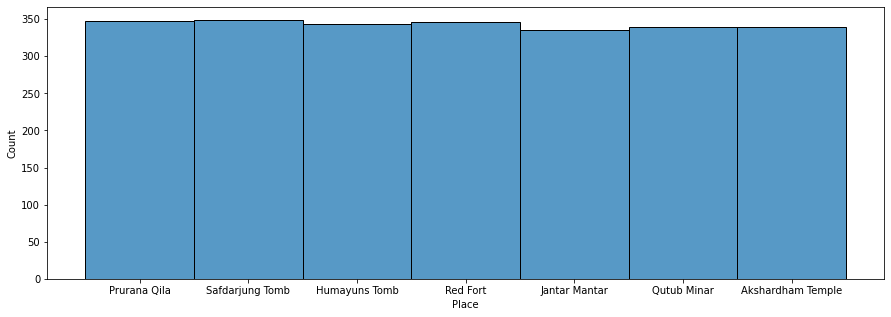

In [ ]:
fig = plt.figure(figsize=(15,5))
sns.histplot(x='Place', data=df)

Selecting a location for further analysis and prediction.

In [ ]:
location_of_analysis = 'Qutub Minar'
capacity_of_location = 0

Filtering the dataset for the location of our interest.

In [ ]:
df = df[df['Place'].str.contains(location_of_analysis)]

In [ ]:
df.head(5)

,id,Name,Date,Timestamp,Place,In Time,Total
9,10,Hamel Mathieu,09-03-22,Wed,Qutub Minar,12:50,9
11,12,Jeremie Hartless,20-03-22,Sun,Qutub Minar,15:07,6
13,14,Katheryn Sitford,05-03-22,Sat,Qutub Minar,12:57,7
24,25,Avrom Phalip,13-03-22,Sun,Qutub Minar,13:19,14
31,32,Astrid Bristowe,05-03-22,Sat,Qutub Minar,11:00,12


Make dataframe of exit data collected from camera.

In [ ]:
df_exits = pd.read_csv('travio_exits.csv')

In [ ]:
df_exits.head(5)

,date,time,exits
0,15-03-2022,15:03,3
1,08-02-2022,10:00,5
2,13-02-2022,9:43,4
3,22-02-2022,9:26,1
4,09-03-2022,16:07,1


To suppress some unnecessary warings.

In [ ]:
pd.options.mode.chained_assignment = None

Creating a datetime column from In Time and Date

In [ ]:
df['datetime'] = pd.to_datetime(df['In Time']+' '+df['Date'], format='%H:%M %d-%m-%y')

Converting the various columns from string to datetime type

In [ ]:
df['Hour'] = df['datetime'].dt.hour
df['Date'] = df['datetime'].dt.date
df['In Time'] = df['datetime'].dt.time

Extracting the week numbers from dates

In [ ]:
df['week_number'] = df['datetime'].dt.isocalendar().week

Making Timestamp column categorical.

In [ ]:
cats = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
df['Timestamp'] = pd.Categorical(df['Timestamp'], categories=cats, ordered=True)

The total number of weeks represented in the data.

In [ ]:
no_of_weeks = len(df['week_number'].unique())

Make a date time column from time and date for exits data.

In [ ]:
df_exits['datetime'] = pd.to_datetime(df_exits['time']+' '+df_exits['date'], format='%H:%M %d-%m-%Y')

# Analysis of the data.

**Predictive Analysis**

Goal — Using historical or current data to find patterns to make predictions about the future

Description:

Accuracy of the predictions depends on the input variables
Accuracy also depends on the types of models, a linear model might work well in some cases, and vice-versa
Using a variable to predict another doesn’t denote a causal relationships

In short it takes data from the past and present to make predictions about the future.

## Columns and their description.

In [ ]:
df.columns

Index(['id', 'Name', 'Date', 'Timestamp', 'Place', 'In Time', 'Total',
       'datetime', 'Hour', 'week_number'],
      dtype='object')

- id : A numeric identifier for each visitor.
- Name: Name of visitor.
- Date: The date of visit of the visitor.
- Timestamp (basically 'Day' a mistake during generation of data): Day of the week.
- Place: The location of visit.
- In Time: The time of scan of the QR Code at entry.
- Total: The totalnumber of entries at that point of time.
- datetime: The combined Date+Time data.
- Hour: The hour slot of entry.
- week_number: The number of week of that year.


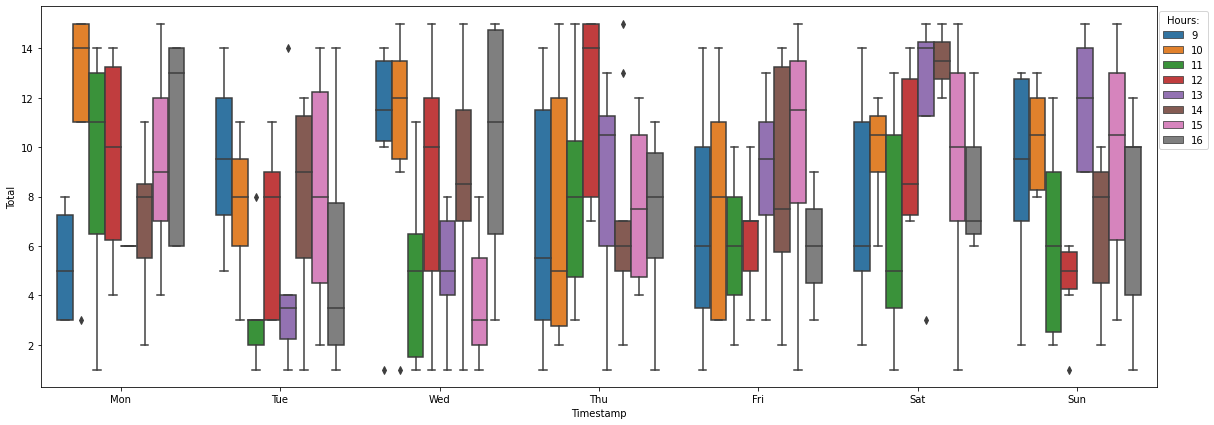

In [ ]:
fig = plt.figure(figsize=(20,7))
sns.boxplot(x="Timestamp", y="Total", hue="Hour", data=df)
plt.legend(title='Hours:',bbox_to_anchor=(1.05, 1), loc=1)

## Visits grouped into weekdays

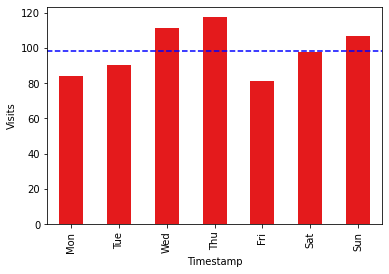

In [ ]:
df.groupby('Timestamp')['Total'].sum().divide(other=no_of_weeks).plot(kind='bar',colormap = 'Set1')
plt.ylabel('Visits')
capacity_of_location = df.groupby('Timestamp')['Total'].sum().divide(other=no_of_weeks).values.mean()
plt.hlines(capacity_of_location, xmin = -1, xmax=7, linestyles='dashed', label='mean visits', colors='b')

## Visits grouped into time slots

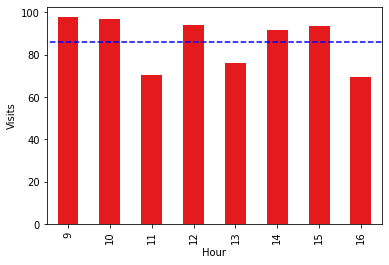

In [ ]:
df.groupby('Hour')['Total'].sum().divide(other=no_of_weeks).plot(kind='bar',colormap = 'Set1')
plt.ylabel('Visits')
capacity_of_location = df.groupby('Hour')['Total'].sum().divide(other=no_of_weeks).values.mean()
plt.hlines(capacity_of_location,xmin = -1, xmax=8,linestyles='dashed', label='mean visits',colors='b')

## Visits for time slots for each weekday

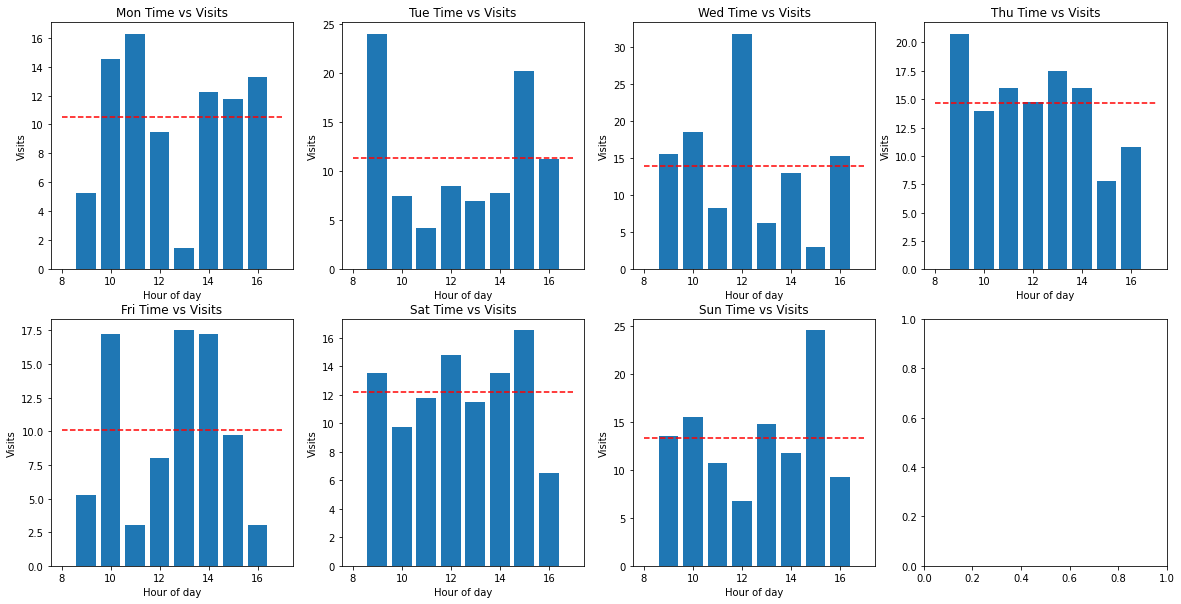

In [ ]:
fig, ax = plt.subplots(ncols=4,nrows=2, figsize = (20,10))
index = 0
ax = ax.flatten()
for weekday in cats:
    ax[index].bar(df.groupby(['Timestamp','Hour'])['Total'].sum()[(weekday)].index, df.groupby(['Timestamp','Hour'])['Total'].sum().divide(other=no_of_weeks)[(weekday)].values)
    ax[index].set_ylabel('Visits')
    ax[index].set_xlabel('Hour of day')
    ax[index].set_title(weekday+' Time vs Visits')
    capacity_of_location = df.groupby(['Timestamp','Hour'])['Total'].sum().divide(other=no_of_weeks)[(weekday)].values.mean()
    ax[index].hlines(capacity_of_location, xmin = 8, xmax=17,linestyles='dashed', label='mean visits',colors='r')
    index+=1

## Prepare dataframe for time series analysis and modeling

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 340 entries, 9 to 2397
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           340 non-null    int64         
 1   Name         340 non-null    object        
 2   Date         340 non-null    object        
 3   Timestamp    340 non-null    category      
 4   Place        340 non-null    object        
 5   In Time      340 non-null    object        
 6   Total        340 non-null    int64         
 7   datetime     340 non-null    datetime64[ns]
 8   Hour         340 non-null    int64         
 9   week_number  340 non-null    UInt32        
dtypes: UInt32(1), category(1), datetime64[ns](1), int64(3), object(4)
memory usage: 34.3+ KB


In [ ]:
df_exits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      400 non-null    object        
 1   time      400 non-null    object        
 2   exits     400 non-null    int64         
 3   datetime  400 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 12.6+ KB


In [ ]:
#df = df[df['week_number']>(max(df['week_number'].unique())-3)]

### Sorting the data by date time to make time series

In [ ]:
df_sorted = df.sort_values('datetime')
df_exits = df_exits.sort_values('datetime')

In [ ]:
df_sorted.head(5)

,id,Name,Date,Timestamp,Place,In Time,Total,datetime,Hour,week_number
1151,452,Robbi Varren,2022-03-01,Tue,Qutub Minar,09:06:00,8,2022-03-01 09:06:00,9,9
1849,450,Richard Hulke,2022-03-01,Tue,Qutub Minar,09:39:00,5,2022-03-01 09:39:00,9,9
617,618,Grange MacCallester,2022-03-01,Tue,Qutub Minar,09:53:00,8,2022-03-01 09:53:00,9,9
307,308,Lannie Brisland,2022-03-01,Tue,Qutub Minar,11:31:00,3,2022-03-01 11:31:00,11,9
220,221,Isadore Gritland,2022-03-01,Tue,Qutub Minar,11:54:00,3,2022-03-01 11:54:00,11,9


In [ ]:
df_exits.head(5)

,date,time,exits,datetime
225,01-02-2022,9:06,7,2022-02-01 09:06:00
73,01-02-2022,9:23,1,2022-02-01 09:23:00
149,01-02-2022,10:13,6,2022-02-01 10:13:00
171,01-02-2022,10:21,1,2022-02-01 10:21:00
378,01-02-2022,10:50,5,2022-02-01 10:50:00


### Detour: Rough estimation of time taken to visit this place from entry to exit.

In [ ]:
import datetime
diff = []
for (i, row1), (j, row2) in zip(df_sorted.head(10).iterrows(), df_exits.head(10).iterrows()):
  diff.append(row2['datetime'] - row1['datetime'])
print(diff)
average = sum(diff, datetime.timedelta(0)) / len(diff)
print('Rough estimation of time taken is ', average)

[Timedelta('-28 days +00:00:00'), Timedelta('-29 days +23:44:00'), Timedelta('-28 days +00:20:00'), Timedelta('-29 days +22:50:00'), Timedelta('-29 days +22:56:00'), Timedelta('-29 days +21:18:00'), Timedelta('-29 days +21:28:00'), Timedelta('-29 days +21:47:00'), Timedelta('-29 days +22:58:00'), Timedelta('-28 days +00:10:00')]
Rough estimation of time taken is  -29 days +22:57:06


Making seconds and minutes as zero to make hourly slots of the data and to predict crowd for each slot.

In [ ]:
df_sorted['datetime'] = pd.to_datetime(df_sorted['datetime']).dt.floor('H')
df_exits['datetime'] = pd.to_datetime(df_exits['datetime']).dt.floor('H')

In [ ]:
# df_sorted.drop_duplicates(inplace=True)
# df_exits.drop_duplicates(inplace=True)

Setting date time column as index of dataframe for time series analyis.

In [ ]:
df_ts = df_sorted[['datetime', 'Total']].set_index('datetime')
df_ts_exits = df_exits[['datetime', 'exits']].set_index('datetime')

Resampling the series to hourly frequency to make continuous data without any gaps.

In [ ]:
df_ts = df_ts.resample('H').sum().ffill().reset_index()
df_ts_exits = df_ts_exits.resample('H').sum().ffill().reset_index()

In [ ]:
df_ts.set_index('datetime',inplace=True)
df_ts_exits.set_index('datetime',inplace=True)

In [ ]:
df_ts.head(5)

,Total
datetime,
2022-03-01 09:00:00,21
2022-03-01 10:00:00,0
2022-03-01 11:00:00,6
2022-03-01 12:00:00,0
2022-03-01 13:00:00,1


In [ ]:
df_ts_exits.head(5)

,exits
datetime,
2022-02-01 09:00:00,8
2022-02-01 10:00:00,12
2022-02-01 11:00:00,4
2022-02-01 12:00:00,3
2022-02-01 13:00:00,2


#### Intersecting the Entry dataframe and the exits dataframe to have common time period. Having common time period means we can subtract the entry and exit to get approximate estimation of the crowd present in that given time slot.

In [ ]:
intersecting_idx = df_ts_exits.index.intersection(df_ts.index)

In [ ]:
df_ts = df_ts.loc[intersecting_idx]

In [ ]:
df_ts.head(5)

,Total
datetime,
2022-03-01 09:00:00,21
2022-03-01 10:00:00,0
2022-03-01 11:00:00,6
2022-03-01 12:00:00,0
2022-03-01 13:00:00,1


In [ ]:
df_ts_exits = df_ts_exits.loc[intersecting_idx]

In [ ]:
df_ts_exits.head(5)

,exits
datetime,
2022-03-01 09:00:00,9
2022-03-01 10:00:00,12
2022-03-01 11:00:00,1
2022-03-01 12:00:00,0
2022-03-01 13:00:00,6


### Get present crowd value from entry and exit data series for each time slot.

In [ ]:
df_ts = df_ts['Total'].subtract(df_ts_exits['exits'])

In [ ]:
df_ts.head(5)

datetime
2022-03-01 09:00:00    12
2022-03-01 10:00:00   -12
2022-03-01 11:00:00     5
2022-03-01 12:00:00     0
2022-03-01 13:00:00    -5
dtype: int64

In [ ]:
df_ts[df_ts < 0] = 0

In [ ]:
df_ts.head(5)

datetime
2022-03-01 09:00:00    12
2022-03-01 10:00:00     0
2022-03-01 11:00:00     5
2022-03-01 12:00:00     0
2022-03-01 13:00:00     0
dtype: int64

## Time series modeling

#### **Visualization of the time series data**

Text(0, 0.5, 'Crowd count -->')

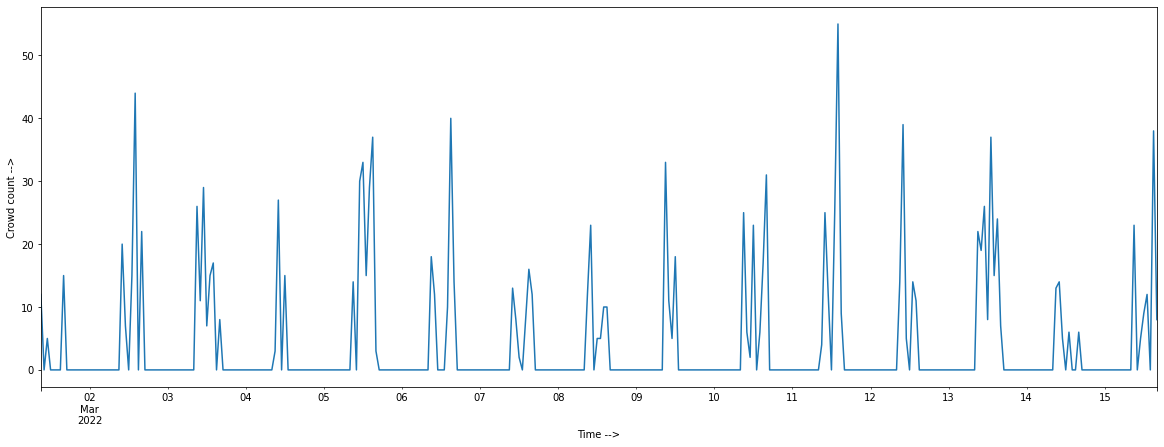

In [ ]:
df_ts.plot(figsize=(20,7))
plt.xlabel('Time -->')
plt.ylabel('Crowd count -->')

Adfuller stats to check for stationarity.

In [ ]:
result = adfuller(df_ts.values,autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print('Critial Values:')
for key, value in result[4].items():
    print(f'  {key}: {value}')

ADF Statistic: -7.821819082622866
p-value: 6.639013340429399e-12
Critial Values:
  1%: -3.45050711373316
  5%: -2.8704195794076743
  10%: -2.571500856923753


- p-value must be less than 0.05 and ADF statistic must be less than the critical values to conform stationarity.

- Stationarity means that the statistical properties of a time series do not change over time. Stationarity is important because many useful analytical tools and statistical tests and models rely on it.

### **Choosing the trend and seasonal elements (p,d,q)x(P,D,Q)s.**

The autocorrelation function (ACF) is a statistical technique that we can use to identify how correlated the values in a time series are with each other. Thus, autocorrelation is the correlation between a time series (signal) and a delayed version of itself.

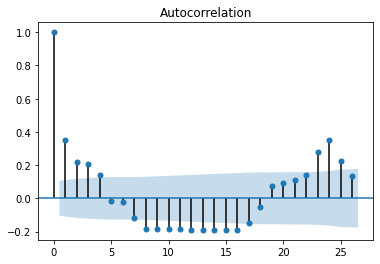

In [ ]:
plot_acf(df_ts)
plt.show()

The decaying values suggest an AR model is relevant for this data.

Partial autocorrelation is a statistical measure that captures the correlation between two variables after controlling for the effects of other variables.

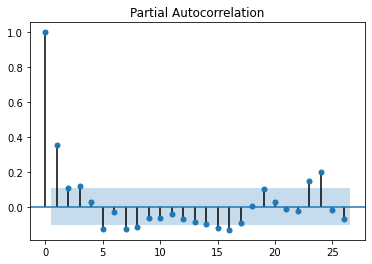

In [ ]:
plot_pacf(df_ts)
plt.show()

We can observe that we have a ar=1(from the significant spikes in PACF plot) and ma=1(from the significant spikes in ACF plot) as more significant thus we can use them in our model here. The periodicity can be set to 24 time periods i.e 24hrs. 

### **GridSearch to find the best values automatically based on AIC Score**

In [ ]:
# code found from here: https://www.bounteous.com/insights/2020/09/15/forecasting-time-series-model-using-python-part-two/

import itertools
import warnings
warnings.filterwarnings("ignore")

def sarima_grid_search(y,seasonal_period):
  p = d = q = range(0, 2)
  pdq = list(itertools.product(p, d, q))
  seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]

  mini = float('+inf')
  
  for param in pdq:
    for param_seasonal in seasonal_pdq:
    #param_seasonal = (param[0], param[1], param[2],seasonal_period)
      try:
        mod = sm.tsa.statespace.SARIMAX(y,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
        results = mod.fit()
        if results.aic < mini:
          mini = results.aic
          param_mini = param
          param_seasonal_mini = param_seasonal
          print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
      except:
        continue
  print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))
  return param_mini, param_seasonal_mini

## **Baseline SARIMA Model**

**Why SARIMA?**

SARIMA is about the seasonality of the dataset. If the data is seasonal, like it will happen after a certain period of time, we need to use SARIMA.

In [ ]:
order, seasonal_order = sarima_grid_search(df_ts,24)

SARIMA(0, 0, 0)x(0, 0, 0, 24) - AIC:2534.952571070025
SARIMA(0, 0, 0)x(0, 0, 1, 24) - AIC:2331.4760678131242
SARIMA(0, 0, 0)x(0, 1, 1, 24) - AIC:2037.384313471145
SARIMA(0, 0, 1)x(0, 1, 1, 24) - AIC:2031.0146566354244
SARIMA(1, 0, 1)x(0, 1, 1, 24) - AIC:2029.9514961417738
The set of parameters with the minimum AIC is: SARIMA(1, 0, 1)x(0, 1, 1, 24) - AIC:2029.9514961417738


In [ ]:
model = sm.tsa.statespace.SARIMAX(endog=df_ts, order=order, seasonal_order=seasonal_order, freq='H')

In [ ]:
history = model.fit()
print(history.summary())

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  344
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 24)   Log Likelihood               -1111.356
Date:                            Tue, 29 Mar 2022   AIC                           2230.712
Time:                                    17:50:43   BIC                           2245.785
Sample:                                03-01-2022   HQIC                          2236.731
                                     - 03-15-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6795      0.327      2.081      0.037       0.039       1.319
ma.L1         -0.5943      0.359   

**The Akaike information criterion (AIC) is an estimator of prediction error and thereby relative quality of statistical models for a given set of data.**

- AIC penalizes a model with too many parameters. **The smaller the AIC score, the better fit the model will be to the data**. This criterion tends to select a model that slightly over fits the data.

P-value tells you the odds that a result occured might be of random chance. All P-values must be < 0.05 for us to consider the coefficient it highly significant.

## **Out of sample prediction**

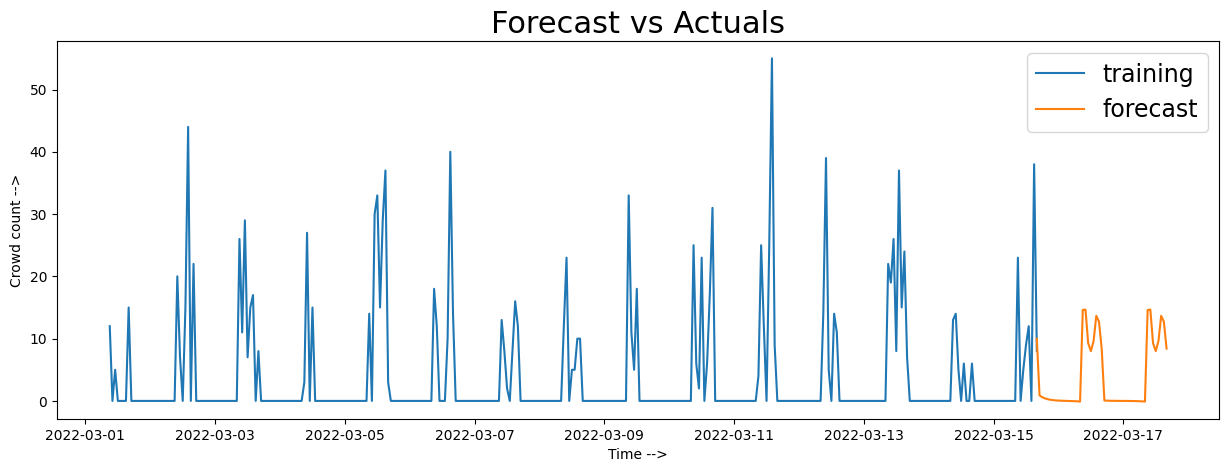

In [ ]:
fc = history.predict(start = df_ts.index[-1], end = df_ts.index[-1]+timedelta(hours=48))
plt.figure(figsize=(15,5), dpi=100)
plt.plot(df_ts, label='training')
plt.plot(fc, label='forecast')
plt.xlabel('Time -->')
plt.ylabel('Crowd count -->')
plt.title('Forecast vs Actuals',fontsize=22)
plt.legend(loc='upper right', fontsize=17)
plt.show()

## **Forecasting for the training data** 

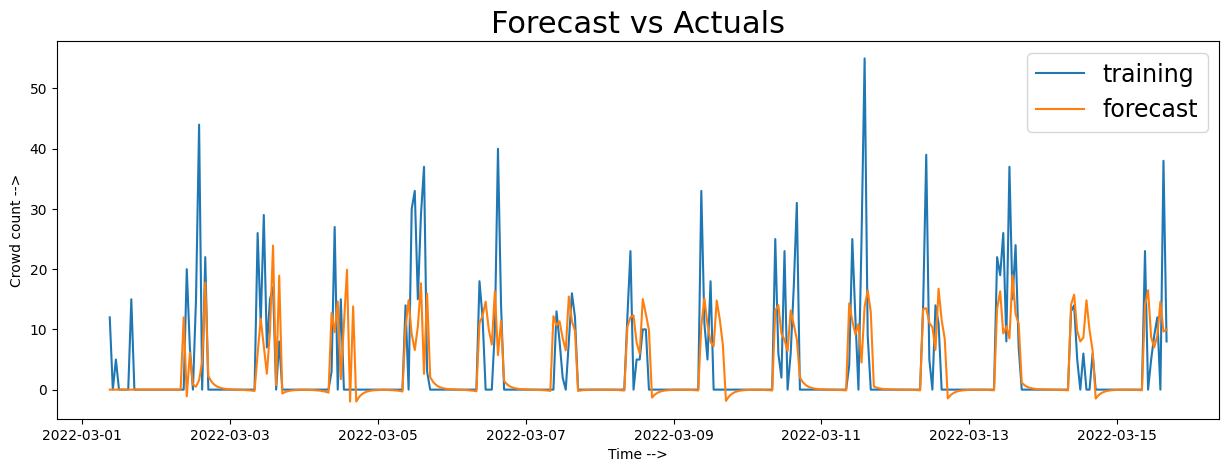

In [ ]:
fc = history.predict(start = df_ts.index[0], end = df_ts.index[-1])
plt.figure(figsize=(15,5), dpi=100)
plt.plot(df_ts, label='training')
plt.plot(fc, label='forecast')
plt.xlabel('Time -->')
plt.ylabel('Crowd count -->')
plt.title('Forecast vs Actuals',fontsize=22)
plt.legend(loc='upper right', fontsize=17)
plt.show()

Mean Absolute error value for SARIMA model =

In [ ]:
mean_absolute_error(df_ts,fc)

3.5595499167095253

## **Facebook Prophet Model**

**Why Facebook Prophet?**

Facebook Prophet is known for being able to handle multiple seasonality better in our case hourly and weekly seasonality and considering holidays.

In [ ]:
from fbprophet import Prophet

Preparing the dataframe for fitting in prophet

In [ ]:
df_prophet = df_ts.reset_index()
df_prophet = df_prophet.rename(columns = {'datetime':'ds',0:'y'}).reset_index().drop(['index'],axis=1)

In [ ]:
df_prophet.head(5)

,ds,y
0,2022-03-01 09:00:00,12
1,2022-03-01 10:00:00,0
2,2022-03-01 11:00:00,5
3,2022-03-01 12:00:00,0
4,2022-03-01 13:00:00,0


Fitting the time series to the model.

In [ ]:
m = Prophet(weekly_seasonality=True)
m.fit(df_prophet)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Make a datetime series for which we need to forecast.

In [ ]:
future = m.make_future_dataframe(periods=0, freq='h')

In [ ]:
future.head(5)

,ds
0,2022-03-01 09:00:00
1,2022-03-01 10:00:00
2,2022-03-01 11:00:00
3,2022-03-01 12:00:00
4,2022-03-01 13:00:00


Forecasting the crowd count for the given series.

In [ ]:
forecast=m.predict(future)

### Visualization of the prediction by model for the time series.

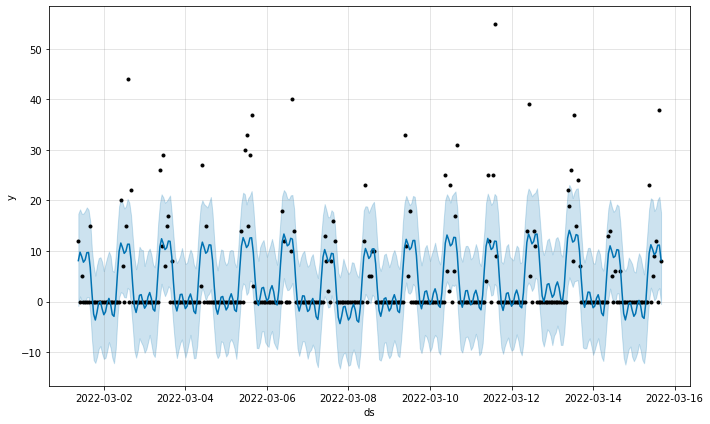

In [ ]:
fig1 = m.plot(forecast)

Mean Absolute error value for Prophet model =

In [ ]:
mean_absolute_error(df_ts,forecast['yhat'])

4.35577017905525

### Visualisation various components of the time series.

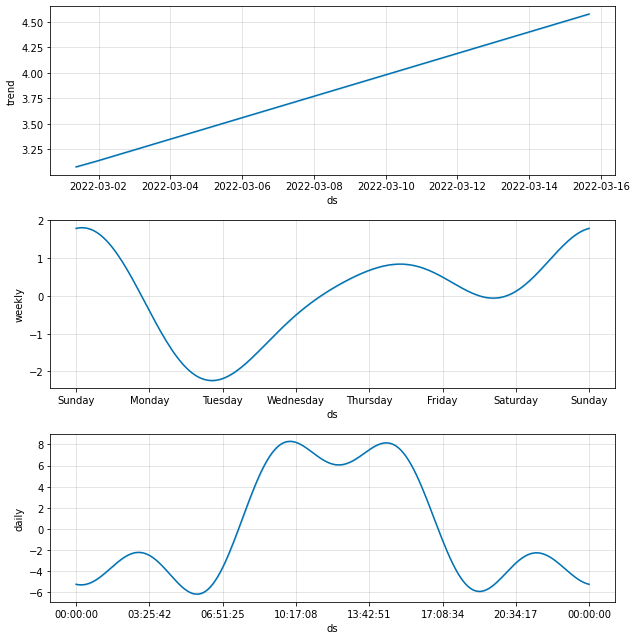

In [ ]:
fig2 = m.plot_components(forecast)

### **Conclusion**

We conclude that the both models are giving reasonable results with randomly generated data and thus needs further analysis and tuning with better data i.e real world data.